In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import IfElseOp

In [2]:
# build entangled Bell pair a for Alica, b for Bob
def create_bell_pair(qc, a, b):
    # put qubit into state |+>
    qc.h(a)
    # cnot: a as control ; b as target
    qc.cx(a, b)

In [3]:
# function to define Alice behavoir
# Alice gonna to send q0
def alice_gates(qc, psi, a):
    # the qubit that gonna to be send
    qc.x(psi)
    qc.cx(psi, a)
    # use Hadamard gate: 50% 0 50% 1
    # create entangeled states
    qc.h(psi)

In [4]:
# measure two qubits from Alice
# store them into classical bits
def measure_and_send(qc, a, b):
    qc.barrier()
    # restore them into classical bits
    qc.measure(a, 0)
    qc.measure(b, 1)

In [5]:
# turn to Bob side
def bob_gates(qc, qubit, crz, crx):
    # conditional logic is used to control the application of gates.
    # allows to apply gates depending on whether the classical bit is set to 1 or 0.
    # qc.if_test to control gates by classical bits
    with qc.if_test((crx,1)):
        # The X gate is a quantum gate that performs a bit-flip operation, 
        # changing |0⟩ to |1⟩ and vice versa.
        qc.x(qubit)
    with qc.if_test((crz, 1)):
        # The Z gate is a quantum gate that performs a phase-flip operation.
        qc.z(qubit)

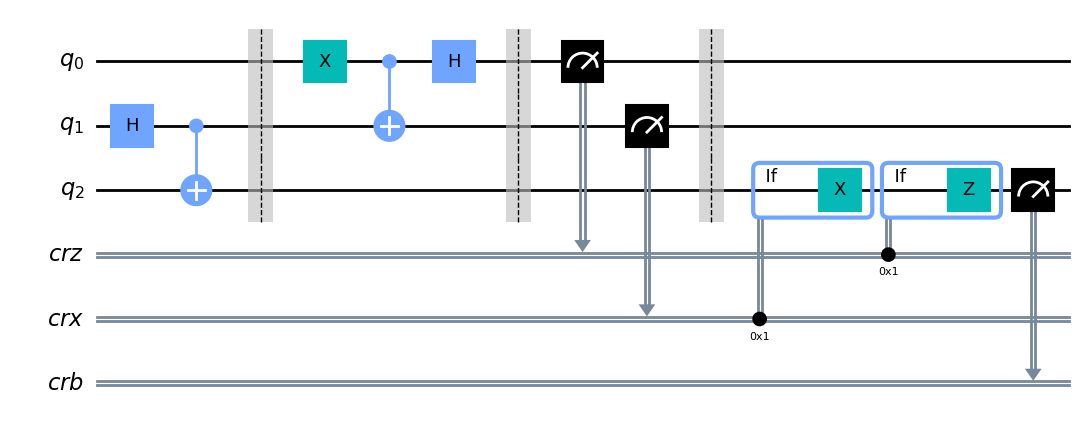

In [6]:
# protool uses 3 qubits and 2 classical bits
# Alice transfer qubits into classical bits and transfer that to Bob
# Bob receive that and trans to qubits again

# initialize register for qubits
qr = QuantumRegister(3, name="q")
# initialize register for bits
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
# idk but one register for Bob's receive
crb = ClassicalRegister(1, name="crb")
# set up teleportation circuit
teleportation_circuit = QuantumCircuit(qr, crz, crx, crb)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)

## STEP 5
crb = ClassicalRegister(1, name="crb")
teleportation_circuit.measure(2,2)
teleportation_circuit.draw(cregbundle=False) # suppress RuntimeWarning with cregbundle=False

In [15]:
from qiskit_ibm_provider import least_busy
from qiskit_ibm_provider import IBMProvider
from qiskit.tools.monitor import job_monitor
from qiskit import * 

In [16]:
hub = "ibm-q"
group = "open"
project = "main"
backend_name = "ibmq_qasm_simulator"
hgp = f"{hub}/{group}/{project}"

In [17]:
# load backend
provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)

#backend = least_busy(provider.backends(dynamic_circuits=True))
print(f"Using backend {backend.name}")

Using backend ibmq_qasm_simulator


In [18]:
# transpile our circuit for the selected backend
backend.target.add_instruction(IfElseOp, name="if_else")
transpiled_circuit = transpile(teleportation_circuit, backend)

In [11]:
# run job 
shots = 1000
job = backend.run(transpiled_circuit, shots=shots, dynamic=True)

/opt/conda/lib/python3.10/site-packages/qiskit_ibm_provider/ibm_backend.py:459: UserWarning: The backend ibmq_qasm_simulator does not support dynamic circuits.
  warnings.warn(f"The backend {self.name} does not support dynamic circuits.")


In [19]:
print(f"Job ID: {job.job_id()}")
job_monitor(job)  # displays job status under cell

Job ID: ckte6uvnetonc3vs3ftg
Job Status: job has successfully run


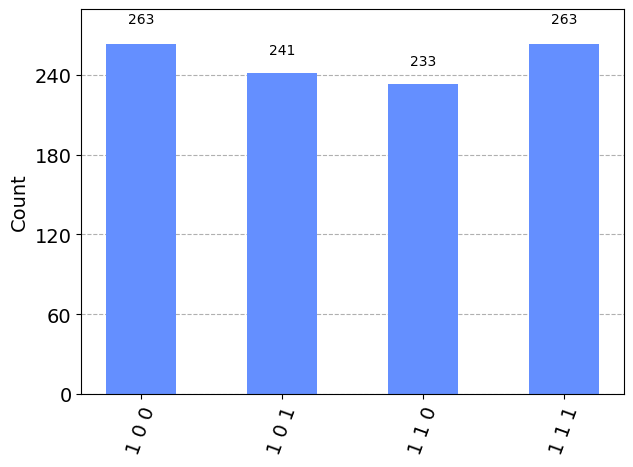

In [20]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
plot_histogram(exp_counts)

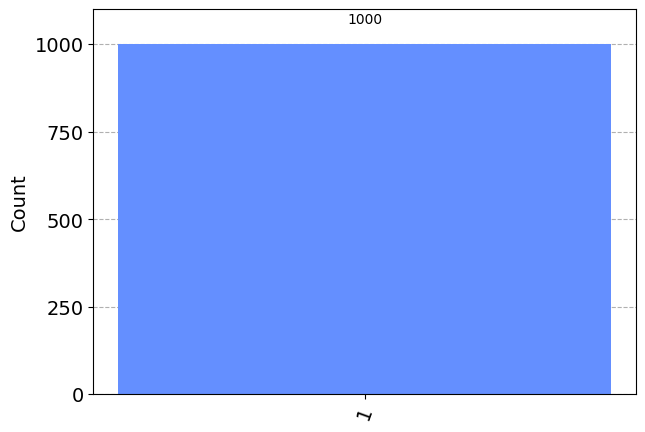

In [21]:
# trace out Bob's results on qubit 2
from qiskit.result import marginal_counts
bobs_qubit = 2
bobs_counts = marginal_counts(exp_counts, [bobs_qubit])
plot_histogram(bobs_counts)

In [22]:
print(f"The experimental error rate : {bobs_counts['1']*100/sum(bobs_counts.values()):.3f}%")

The experimental error rate : 100.000%
